# Data Storytelling: visualizing the DDSM dataset

## Introduction

In this notebook, we'll visualize samples from the DDSM dataset, seeing if we can gain insights from the different classifications. We'll then generate some radiomic features using an open-source package for medical images. A brief description of the dataset is below.

From kaggle:

"
#### Summary
This dataset consists of images from the DDSM [1] and CBIS-DDSM [3] datasets. The images have been pre-processed and converted to 299x299 images by extracting the ROIs. The data is stored as tfrecords files for TensorFlow.

The dataset contains 55,890 training examples, of which 14% are positive and the remaining 86% negative, divided into 5 tfrecords files.

...

#### Pre-processing

...

1. label_normal - 0 for negative and 1 for positive
2. label - full multi-class labels, 0 is negative, 1 is benign calcification, 2 is benign mass, 3 is malignant calcification, 4 is malignant mass

"

### Data we'll use
Since this dataset is rather large, let's just use the validation set as our training set.

## Plotting some sample data

To get a sense of what the dataset looks like, let's see some of the images in our daset. We'll first have to get some samples by grabbing the indeces from the different categories, and then getting the corresponding images form our image matrix.

### Getting the indeces of the sample data from the label array

In [1]:
# add the directory path to the data, which is different from this notebook's directory
import os
import sys
path_data = os.path.abspath('../../../../springboard/project_data/ddsm-mammography/')

In [2]:
# Let's look at the training labels. Since there are 5 different categories, let's look at 5 samples from each category, so a 5x5 plot
import numpy as np
labels = np.load(os.path.join(path_data,'cv10_labels.npy'))

In [3]:
labels

array([0, 0, 2, ..., 0, 0, 0], dtype=int64)

In [4]:
# since our labels is an array, we can just loop to find the first n samples for each category while keeping track of the index. 
# Let's use a dictionary to keep track of the first n samples for each category. We'll loop through our array, and 
# we'll exit the array once all n samples have been satisfied
first_samples = {0: [], 1: [], 2: [], 3: [], 4: []}

break_loop = False
n_samples = 5
for ind, label in enumerate(labels):
    # append to our array if we have 
    if len(first_samples[label]) < n_samples:
        first_samples[label].append(ind)
    
    # check if all categories have n_samples
    bools = []
    for category in first_samples:
        # Check if all of them have n_samples in them
        if (len(first_samples[category]) == n_samples):
            bools.append(True)
        else:
            bools.append(False)
        
    # if all of the categories have n_samples, then we can break our outer loop
    if all(bools):
        break

In [5]:
first_samples

{0: [0, 1, 3, 4, 5],
 1: [13, 26, 62, 76, 79],
 2: [2, 25, 38, 270, 313],
 3: [42, 44, 61, 93, 99],
 4: [143, 263, 805, 1150, 1309]}

### Getting and displaying the corresponding images
Now that we have the first n_samples, we can get the corresponding images and plot them

In [6]:
# Let's load our training data and check out its shape
path_data_train = os.path.join(path_data, 'cv10_data', 'cv10_data.npy')
data_train = np.load(path_data_train)
data_train.shape

(7682, 299, 299, 1)

It looks like our training set consists of 7,682 images stacked along the first dimension, each of them having 299x299 pixels, and each having one channel (i.e., grayscale and not rgb). Let's grab the corresponding images.

In [7]:
# Let's store our images in a dictionary, just like we've been doing with the indeces
data_train_samples = {}
for category, inds in first_samples.items():
    data_train_samples[category] = data_train[inds, :, :, :]

In [8]:
for images in data_train_samples.values():
    print(images.shape)

(5, 299, 299, 1)
(5, 299, 299, 1)
(5, 299, 299, 1)
(5, 299, 299, 1)
(5, 299, 299, 1)


OK, now that we have our sample images, let's plot them!

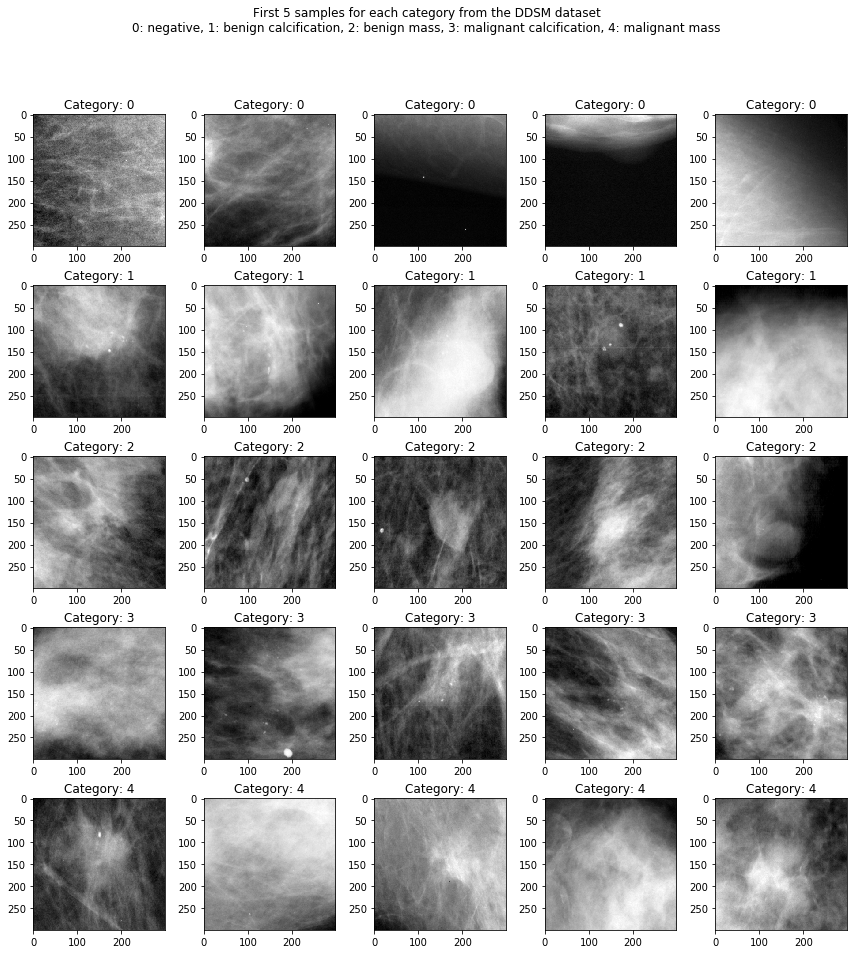

In [9]:
import matplotlib.pyplot as plt

n_rows = len(data_train_samples.keys())
n_cols = n_samples
fig = plt.figure(figsize=(15,15))
fig.suptitle(
    f'First {n_samples} samples for each category from the DDSM dataset\n'
    '0: negative, 1: benign calcification, 2: benign mass, 3: malignant calcification, 4: malignant mass')
for row, category in enumerate(data_train_samples.keys()):
    # Each row in our plot will be a category
    images = data_train_samples[category]
    for col, image in enumerate(images):
        # Each column in our plot will be the nth sample image
        # The i'th element in our matrix is (row)*(n_cols) + col + 1
        ii = (row * n_cols) + col + 1
        fig.add_subplot(n_rows, n_cols, ii)
        plt.imshow(image[:,:, 0], cmap='gray')
        plt.title(f"Category: {category}")

# Adjust the subplot spacing
plt.subplots_adjust(wspace=0.1, hspace=0.3)

### Insights from plots
With only our eyes, it's difficult to detect differences among the groups. Probably one of the more obvious differences between the negative images (category 0) and the rest is the number of calcifications (the bright spots in the images). There are hardly any, and in images that have them, it might be an issue with noise rather than an actual calcification, since an area that's outside of the breast is also bright. Reseach supports this notion; calcifications in breast images typically result in recalls.

As another observation, positive images tend to contain tumors, though it is often difficult to distinguish them from breast parenchyma. This is especially true for breast with dense structural tissue, as these are typically classified as high-density breast. 

Let's see if radiomic features can provide any further insights.


## Generating radiomic features
We'll use an open-source package called PyRadiomics, developed by several medical & research institutions, to extract features.  From the authors:

"Radiomic artificial intelligence (AI) technology, either based on engineered hard-coded algorithms or deep learning methods, can be used to develop noninvasive imaging-based biomarkers. However, lack of standardized algorithm definitions and image processing severely hampers reproducibility and comparability of results. To address this issue, we developed PyRadiomics, a flexible open-source platform capable of extracting a large panel of engineered features from medical images."



### Rescaling intensity of images
To avoid potentially large weights for features, let's rescale the images between 0 and 1.

In [10]:
# Let's check the max and min values of all images, just to make sure that they all use the same range
mins, maxs = zip(*[(np.min(img), np.max(img)) for img in data_train])
    

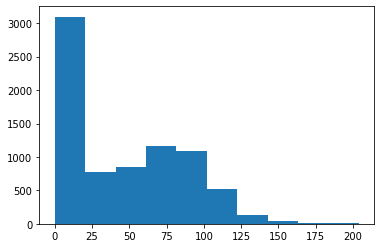

In [11]:
fig1 = plt.hist(mins)

mins

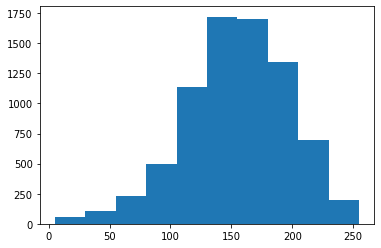

In [12]:
fig2 = plt.hist(maxs)

Looks like all the intensities are 8 bit, so let's divide by 255 to get range = [0, 1]

In [13]:
data_train_int_scaled = np.zeros(data_train.shape)
for ind, img in enumerate(data_train):
    data_train_int_scaled[ind, :, :, :] = img/255

### Creating features

#### Setting up data
To generate features, we need to pass a mask of the image. Since we don't have annotations/segmentations, we'll just use almost the entire image as the mask. PyRadiomics requires at least one pixel to be 0, so we'll null the top-left corner of the maask.  Furthermore, since all images are the same shape, we can just use the same mask.

In [14]:
mask = np.ones((data_train_int_scaled[0,][:, :, 0]).shape).astype(int)
mask[0, 0] = 0
print(mask.shape)
mask

(299, 299)


array([[0, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In addition to having a mask, we also need to save the images as files, since the input objects to PyRadiomics functions are paths. Specifically, we'll save them as nrrd arrays. Let's try one example and inspect the resulting image and mask.

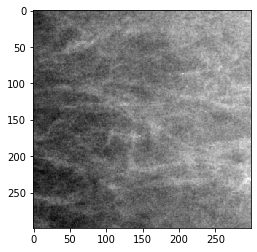

In [15]:
import nrrd
import SimpleITK as sitk

parent_dir = 'D:/springboard/project_data/ddsm-mammography/training_nrrds/'
path_mask_nrrd = os.path.join(parent_dir, 'mask.nrrd')
nrrd.write(path_mask_nrrd, mask, index_order='C')
mask_sitk = sitk.ReadImage(path_mask_nrrd)

path_img_nrrd = os.path.join(parent_dir, 'test_img.nrrd')
img_arr = data_train_int_scaled[0,][:, :, 0]
nrrd.write(path_img_nrrd, img_arr, index_order='C')
img_sitk = sitk.ReadImage(path_img_nrrd)
plt.imshow(sitk.GetArrayFromImage(img_sitk), cmap='gray')

In [16]:
sitk.GetArrayFromImage(mask_sitk)

array([[0, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

OK, now let's store the the rest of our training data as images.

In [17]:
paths_nrrd = []
for idx, img in enumerate(data_train_int_scaled):
    img_arr = img[:, :, 0]
    path_nrrd = os.path.join(parent_dir, f'train_{idx}.nrrd')
    # nrrd.write(path_nrrd, img_arr, index_order='C')
    paths_nrrd.append(path_nrrd)

In [18]:
len(paths_nrrd)

7682

#### Using an extractor object to create features
Let's create an extractor object, and then test in on one sample to see what features we get.

In [19]:
# Instantiate the extractor
from radiomics import featureextractor
extractor = featureextractor.RadiomicsFeatureExtractor()
print('Extraction parameters:\n\t', extractor.settings)
print('\nEnabled filters:\n\t', extractor.enabledImagetypes)
print('\nEnabled features:\n\t', extractor.enabledFeatures)



Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}

Enabled filters:
	 {'Original': {}}

Enabled features:
	 {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}


In [20]:
# Extract the features
result = extractor.execute(img_sitk, mask_sitk)

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [21]:
# Get only the features of the original image. There are no shape features, which is OK, 
# since our mask was just the entire image.
import six
feature = np.array([])
feature_names = []
for key, value in six.iteritems(result):
    if key.startswith("original_"):
        feature = np.append(feature, value)
        feature_names.append(key)

print(len(feature))
feature


93


array([ 4.54901961e-01,  5.33333333e-01,  2.18524070e+04, -3.20342650e-16,
        4.70588235e-02,  2.33959354e+00,  6.00000000e-01,  2.45897073e-02,
        4.93516910e-01,  4.94117647e-01,  4.03921569e-01,  1.96078431e-01,
        1.89978757e-02,  4.94402753e-01, -5.73502048e-02,  2.18524070e+04,
        1.00000000e+00,  8.75141826e-04,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00, -3.20342650e-16,  0.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
       -3.20342650e-16,  1.00000000e+00,  1.00000000e+00,  2.00000000e+00,
       -3.20342650e-16,  0.00000000e+00,  1.02864910e-01,  8.70476272e+04,
        9.73687105e-01,  1.18998653e-01,  8.94000000e+04,  0.00000000e+00,
        1.00000000e+00,  8.03993960e+01,  8.03993960e+01,  8.03993960e+01,
        1.00000000e+00,  

OK, now that we've seen the features for one, let's make features for all of the training images and store them in a pandas DataFrame.

In [61]:
import pandas as pd
# preallocate our dictionary of features
features_dict = {}
for feature_name in feature_names:
    features_dict[feature_name] = []
    
# create features for each image
for path_nrrd in paths_nrrd:
    img_sitk = sitk.ReadImage(path_nrrd)
    result = extractor.execute(img_sitk, mask_sitk)
    
    # save only the original features
    for key, value in six.iteritems(result):
        if key.startswith("original_"):
            features_dict[key].append(value)

df = pd.DataFrame(features_dict)


Inspect the df, see if it looks OK.

In [23]:
df.head()

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,0.45490196078431366,0.5333333333333333,21852.406966551323,-3.203426503814917e-16,0.04705882352941182,2.339593535668208,0.6,0.02458970730282714,0.4935169101197525,0.49411764705882355,...,1.2511948911210206e-10,1.2511948911210206e-10,-3.203426503814917e-16,1.1185682326621925e-05,0.0,0.0,1000000.0,0.0,0.0,0.0
1,0.25098039215686274,0.4117647058823529,11119.14285274894,-3.203426503814917e-16,0.0862745098039216,3.121322244997307,0.5843137254901961,0.04946942934816475,0.347113918498048,0.3607843137254902,...,1.2511948911210206e-10,1.2511948911210206e-10,-3.203426503814917e-16,1.1185682326621925e-05,0.0,0.0,1000000.0,0.0,0.0,0.0
2,0.3137254901960784,0.5098039215686274,16583.70360630527,-3.203426503814917e-16,0.10980392156862745,2.2230009212070097,0.615686274509804,0.06037598571047114,0.4245378339255166,0.43529411764705883,...,1.2511948911210206e-10,1.2511948911210206e-10,-3.203426503814917e-16,1.1185682326621925e-05,0.0,0.0,1000000.0,0.0,0.0,0.0
3,0.08627450980392157,0.26666666666666666,2429.438615916955,-3.203426503814917e-16,0.10980392156862746,2.650332567996092,0.5607843137254902,0.0613963345877666,0.14824134754572968,0.12156862745098039,...,1.2511948911210206e-10,1.2511948911210206e-10,-3.203426503814917e-16,1.1185682326621925e-05,0.0,0.0,1000000.0,0.0,0.0,0.0
4,0.07450980392156861,0.2901960784313726,2154.621084198385,-3.203426503814917e-16,0.047058823529411764,4.652982384141304,0.4549019607843137,0.06951116142975364,0.1267027240426372,0.0784313725490196,...,1.2511948911210206e-10,1.2511948911210206e-10,-3.203426503814917e-16,1.1185682326621925e-05,0.0,0.0,1000000.0,0.0,0.0,0.0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7682 entries, 0 to 7681
Data columns (total 93 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   original_firstorder_10Percentile                    7682 non-null   object
 1   original_firstorder_90Percentile                    7682 non-null   object
 2   original_firstorder_Energy                          7682 non-null   object
 3   original_firstorder_Entropy                         7682 non-null   object
 4   original_firstorder_InterquartileRange              7682 non-null   object
 5   original_firstorder_Kurtosis                        7682 non-null   object
 6   original_firstorder_Maximum                         7682 non-null   object
 7   original_firstorder_MeanAbsoluteDeviation           7682 non-null   object
 8   original_firstorder_Mean                            7682 non-null   object
 9   original

In [25]:
df.head()

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,0.45490196078431366,0.5333333333333333,21852.406966551323,-3.203426503814917e-16,0.04705882352941182,2.339593535668208,0.6,0.02458970730282714,0.4935169101197525,0.49411764705882355,...,1.2511948911210206e-10,1.2511948911210206e-10,-3.203426503814917e-16,1.1185682326621925e-05,0.0,0.0,1000000.0,0.0,0.0,0.0
1,0.25098039215686274,0.4117647058823529,11119.14285274894,-3.203426503814917e-16,0.0862745098039216,3.121322244997307,0.5843137254901961,0.04946942934816475,0.347113918498048,0.3607843137254902,...,1.2511948911210206e-10,1.2511948911210206e-10,-3.203426503814917e-16,1.1185682326621925e-05,0.0,0.0,1000000.0,0.0,0.0,0.0
2,0.3137254901960784,0.5098039215686274,16583.70360630527,-3.203426503814917e-16,0.10980392156862745,2.2230009212070097,0.615686274509804,0.06037598571047114,0.4245378339255166,0.43529411764705883,...,1.2511948911210206e-10,1.2511948911210206e-10,-3.203426503814917e-16,1.1185682326621925e-05,0.0,0.0,1000000.0,0.0,0.0,0.0
3,0.08627450980392157,0.26666666666666666,2429.438615916955,-3.203426503814917e-16,0.10980392156862746,2.650332567996092,0.5607843137254902,0.0613963345877666,0.14824134754572968,0.12156862745098039,...,1.2511948911210206e-10,1.2511948911210206e-10,-3.203426503814917e-16,1.1185682326621925e-05,0.0,0.0,1000000.0,0.0,0.0,0.0
4,0.07450980392156861,0.2901960784313726,2154.621084198385,-3.203426503814917e-16,0.047058823529411764,4.652982384141304,0.4549019607843137,0.06951116142975364,0.1267027240426372,0.0784313725490196,...,1.2511948911210206e-10,1.2511948911210206e-10,-3.203426503814917e-16,1.1185682326621925e-05,0.0,0.0,1000000.0,0.0,0.0,0.0


#### Plotting features
Let's plot the means of all features to get an idea of scale and potential significance.

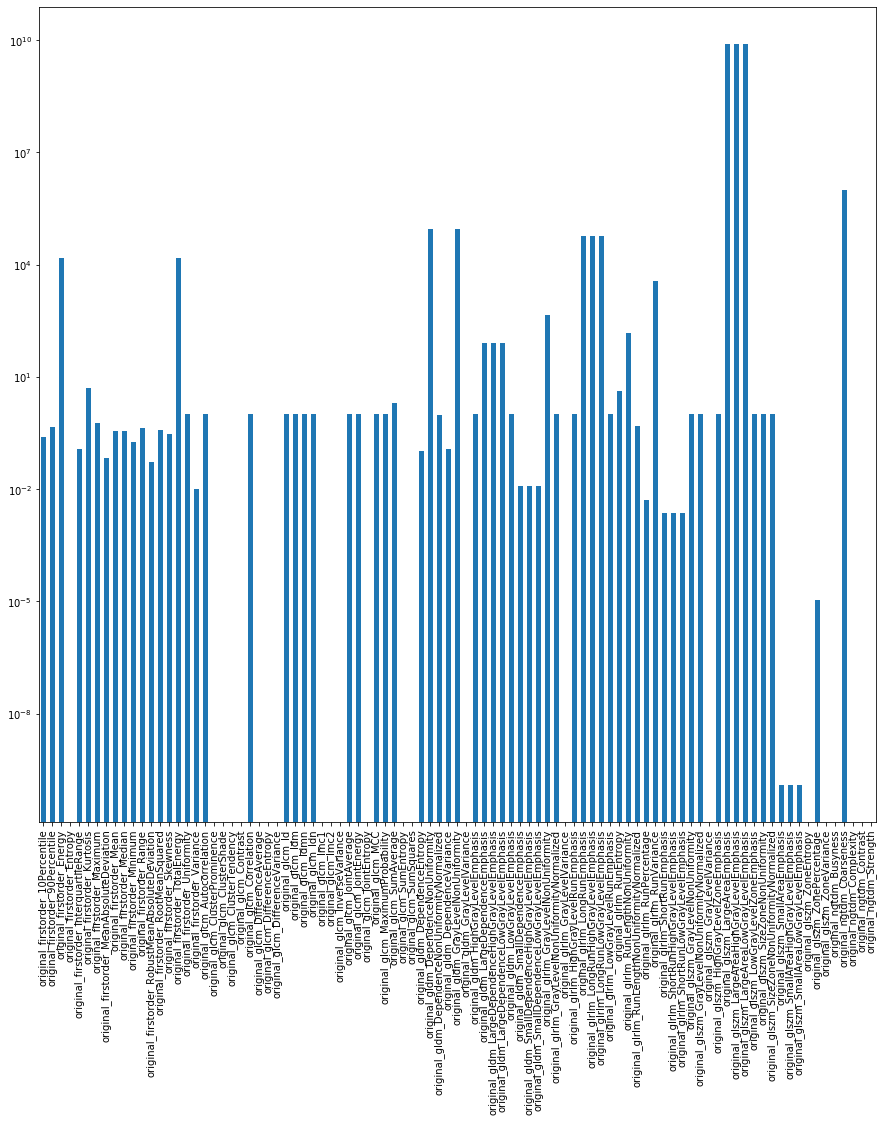

In [56]:
df_mean = df[df.columns].mean()
fig2 = df_mean.plot(rot=90, figsize=(15,15), logy=True, kind='bar')
fig2.set_xticks(range(len(df_mean)))
fig2.set_xticklabels(list(df_mean.index))
fig2

## Nex steps
After creating our features and plotting the means, it looks like there is some potential for creating a prediction model. In the next steps, we'll have to evaluate which variables would be significant in our prediction model.  Since we are not using an actual mask, our model will not take geometry into consideration as a feature. There are other features, however, that measure other morphological patterns in the imamges that could be significant contributors to our model. Let's save our features in a .csv to continue the analysis in another notebook.

In [60]:
df.to_csv(os.path.abspath(os.path.join('.', 'ddsm_pyradiomics_features.csv')))